# 🌊 FlowMixer: Constrained Neural Architecture for Interpretable Spatiotemporal Forecasting

**FlowMixer** introduces a novel neural architecture that leverages constrained matrix operations within a reversible mapping framework to achieve interpretable spatiotemporal forecasting. This implementation demonstrates the key innovations from our paper:

## 🔑 Key Innovations

* **Kronecker-Koopman Eigenmode Framework**: Provides interpretable spatiotemporal patterns through eigendecomposition of mixing matrices
* **Constrained Non-negative Matrix Mixing**: Time mixing uses positive definite matrices (W_t = αI + W×W) while feature mixing employs stochastic attention mechanisms  
* **Semi-group Properties**: Enable algebraic manipulation of prediction horizons without retraining
* **Architectural Simplicity**: Single mixing block eliminates hyperparameter tuning for layer depth

## 🏗️ Architecture Overview

The core transformation follows: **F(X) = φ⁻¹(W_t φ(X) W_f^T)** where:
- φ: Reversible mapping (RevIN) handling distribution shifts
- W_t: Time mixing matrix with positive eigenvalues
- W_f: Feature mixing matrix with stochastic properties
- The Kronecker product W_f ⊗ W_t enables spatiotemporal eigenmode decomposition

## 📊 Experimental Focus

This notebook focuses on **time series forecasting** with comprehensive support for:
- Multiple datasets (ETT family, Weather, Traffic)
- Various mixer types (standard, exponential, periodic, exponential-periodic)  
- Advanced training techniques (EMA, Mixup, gradient clipping)
- Flexible optimization (SGD, AdamW with scheduling)
- **Interactive Kronecker-Koopman eigenmode analysis**

The implementation preserves all architectural intricacies while providing tools for interpretability analysis.


In [18]:
# @title Setup & Imports
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import math, time, warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 888; np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed(SEED); torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualization setup
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"🚀 Device: {device}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎯 Random seed: {SEED}")
print("✅ Setup complete!")

🚀 Device: cuda
🔥 PyTorch version: 2.6.0+cu124
🎯 Random seed: 888
✅ Setup complete!


In [19]:
# @title Data Handling & Preprocessing

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len, target_slice=None):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.seq_len, self.pred_len, self.total_len = seq_len, pred_len, seq_len + pred_len
        self.target_slice = target_slice

    def __len__(self): return len(self.data) - self.total_len + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        if self.target_slice is not None: y = self.data[idx + self.pred_len:idx + self.pred_len + self.seq_len, self.target_slice]
        else: y = self.data[idx + self.pred_len:idx + self.pred_len + self.seq_len]
        return x, y

class DatasetManager:
    def __init__(self, data, batch_size, seq_len, pred_len, feature_type='M', target='OT'):
        self.data, self.batch_size = data, batch_size
        self.seq_len, self.pred_len = seq_len, pred_len
        self.feature_type, self.target = feature_type, target
        self.target_slice, self.n_feature = None, 1
        self._read_data()

    def _read_data(self):
        LOCAL_CACHE_DIR = './data/'
        if not os.path.isdir(LOCAL_CACHE_DIR): os.mkdir(LOCAL_CACHE_DIR)
        cache_filepath = os.path.join('./data/', self.data + '.csv')
        df_raw = pd.read_csv(cache_filepath); df = df_raw.set_index('date')
        if self.feature_type == 'S': df = df[[self.target]]  # Univariate
        elif self.feature_type == 'MS':  # Multivariate-univariate
            target_idx = df.columns.get_loc(self.target)
            self.target_slice = slice(target_idx, target_idx + 1)
        n = len(df)
        if self.data.startswith('ETTm'):
            train_end, val_end = 12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4
            test_end = val_end + 4 * 30 * 24 * 4
        elif self.data.startswith('ETTh'):
            train_end, val_end = 12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24
            test_end = val_end + 4 * 30 * 24
        else: train_end, val_end, test_end = int(n * 0.7), n - int(n * 0.2), n
        train_df, val_df = df[:train_end], df[train_end - self.seq_len:val_end]
        test_df = df[val_end - self.seq_len:test_end]
        self.scaler = StandardScaler().fit(train_df.values)
        def scale_df(df, scaler):
            data = scaler.transform(df.values)
            return pd.DataFrame(data, index=df.index, columns=df.columns)
        self.train_df = scale_df(train_df, self.scaler)
        self.val_df = scale_df(val_df, self.scaler)
        self.test_df = scale_df(test_df, self.scaler)
        self.n_feature = self.train_df.shape[-1]

    def inverse_transform(self, data):
        if isinstance(data, torch.Tensor): data = data.cpu().numpy()
        return self.scaler.inverse_transform(data)

    def get_dataloaders(self):
        train_dataset = TimeSeriesDataset(self.train_df, self.seq_len, self.pred_len, self.target_slice)
        val_dataset = TimeSeriesDataset(self.val_df, self.seq_len, self.pred_len, self.target_slice)
        test_dataset = TimeSeriesDataset(self.test_df, self.seq_len, self.pred_len, self.target_slice)
        return (
            DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False),
            DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False),
            DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)
        )

print("📊 Data handling classes loaded")

📊 Data handling classes loaded


In [20]:
# @title FlowMixer Model Components

# ==================== MIXUP IMPLEMENTATION ====================
def mixup_data(x, y, alpha=0.2, combine=False):
    """Apply mixup augmentation to batch with option to combine or replace."""
    if alpha <= 0: return x, y
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    if combine:
        return torch.cat([x, mixed_x], dim=0), torch.cat([y, mixed_y], dim=0)
    else:
        return mixed_x, mixed_y

# ==================== EMA IMPLEMENTATION ====================
class EMA(nn.Module):
    """Exponential Moving Average for model weights."""
    def __init__(self, model, decay=0.999):
        super().__init__()
        self.model = model
        self.decay = decay
        self.register_buffer('total_iterations', torch.tensor(0, dtype=torch.int))
        # Initialize EMA model with just parameters (not buffers)
        self.shadow = OrderedDict()
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.clone().detach()

    def update(self):
        self.total_iterations += 1
        decay = min(self.decay, (1 + self.total_iterations) / (10 + self.total_iterations))  # Calculate decay with warmup
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    self.shadow[name] = decay * self.shadow[name] + (1 - decay) * param.clone().detach()  # Update EMA parameters

    def apply_shadow(self):
        """Apply EMA weights to the model for evaluation"""
        original_params = OrderedDict()
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                original_params[name] = param.clone().detach()
                param.data.copy_(self.shadow[name])
        return original_params

    def restore_original(self, original_params):
        """Restore original weights after evaluation"""
        for name, param in self.model.named_parameters():
            if name in original_params:
                param.data.copy_(original_params[name])

# ==================== MODEL COMPONENTS ====================
class RevNorm(nn.Module):
    def __init__(self, feature_dim, axis=1, eps=1e-5, affine=True, revin=1, seq_len=1024):
        super(RevNorm, self).__init__()
        self.axis, self.eps, self.affine, self.revin, self.seq_len = axis, eps, affine, revin, seq_len
        if self.affine:
            if self.revin == 1:  # Classic REVIN - feature-wise scaling
                self.affine_weight = nn.Parameter(torch.ones(feature_dim))
                self.affine_bias = nn.Parameter(torch.zeros(feature_dim))
            else:  # TD-REVIN with time-dependent parameters
                self.affine_weight = nn.Parameter(torch.ones(1, seq_len , feature_dim))
                self.affine_bias = nn.Parameter(torch.zeros(1, seq_len , feature_dim))
        self.register_buffer('mean', None); self.register_buffer('stdev', None)

    def _get_statistics(self, x):
        mean = x.mean(dim=self.axis, keepdim=True)
        var = x.var(dim=self.axis, keepdim=True, unbiased=False)
        return mean, torch.sqrt(var + self.eps)

    def forward(self, x, mode='norm'):
        if self.revin > 1 and self.affine and (self.seq_len is None or x.shape[1] != self.seq_len):
            self.seq_len = x.shape[1]
            feat_dim, device = x.shape[2], x.device
        if mode == 'norm':
            self.mean, self.stdev = self._get_statistics(x)
            x = (x - self.mean) / self.stdev
            if self.affine: x = x * (self.affine_weight) + self.affine_bias
        elif mode == 'denorm':
            if self.affine: x = (x - self.affine_bias) / (self.affine_weight)
            x = x * self.stdev + self.mean
        return x

class MixingModule(nn.Module):
    def __init__(self, seq_len, feature_dim):
        super(MixingModule, self).__init__()
        self.seq_len, self.feature_dim = seq_len, feature_dim
        self.W = nn.Parameter(torch.empty(seq_len, seq_len))
        nn.init.xavier_normal_(self.W)
        self.scale_t = nn.Parameter(torch.ones(1))
        self.scale_f = nn.Parameter(torch.ones(1))
        self.K = nn.Parameter(torch.empty(feature_dim, feature_dim))
        self.Q = nn.Parameter(torch.empty(feature_dim, feature_dim))
        nn.init.orthogonal_(self.K); nn.init.orthogonal_(self.Q)
        self.register_buffer('identity_t', torch.eye(seq_len))
        self.register_buffer('identity_f', torch.eye(feature_dim))

    def forward(self, x):
        batch_size, device = x.shape[0], x.device
        Wt = self.scale_t * self.identity_t+ self.W * self.W
        norm_factor = torch.sqrt(torch.tensor(self.feature_dim, dtype=torch.float, device=device))
        attention = F.softmax(self.Q @ self.K.T / norm_factor, dim=0)
        identity_f = torch.eye(self.feature_dim, device=device)
        scale_factor = self.scale_f.pow(2)
        Wf_T = identity_f + scale_factor * attention
        Wf_T = Wf_T / (1.0 + scale_factor)
        return torch.matmul(torch.matmul(Wt, x), Wf_T), Wt, Wf_T

class ExpMixingModule(nn.Module):
    def __init__(self, seq_len, feature_dim):
        super(ExpMixingModule, self).__init__()
        self.seq_len, self.feature_dim = seq_len, feature_dim
        self.W = nn.Parameter(torch.empty(seq_len, seq_len))
        nn.init.xavier_normal_(self.W)
        self.scale_t = nn.Parameter(torch.zeros(1))
        self.scale_f = nn.Parameter(torch.ones(1))
        self.K = nn.Parameter(torch.empty(feature_dim, feature_dim))
        self.Q = nn.Parameter(torch.empty(feature_dim, feature_dim))
        nn.init.orthogonal_(self.K); nn.init.orthogonal_(self.Q)
        self.register_buffer('identity_t', torch.eye(seq_len))
        self.register_buffer('identity_f', torch.eye(feature_dim))

    def forward(self, x):
        batch_size, device = x.shape[0], x.device
        Wt = self.scale_t * self.identity_t + torch.matrix_exp(self.W * self.W)
        norm_factor = torch.sqrt(torch.tensor(self.feature_dim, dtype=torch.float, device=device))
        attention = F.softmax(self.Q @ self.K.T / norm_factor, dim=0)
        identity_f = torch.eye(self.feature_dim, device=device)
        scale_factor = self.scale_f.pow(2)
        Wf_T = identity_f + scale_factor * attention
        Wf_T = Wf_T / (1.0 + scale_factor)
        return torch.matmul(torch.matmul(Wt, x), Wf_T), Wt, Wf_T

class KMixingModule(nn.Module):
    def __init__(self, seq_len, feature_dim, periods=[24, 168]):
        super(KMixingModule, self).__init__()
        self.seq_len, self.feature_dim, self.periods = seq_len, feature_dim, periods
        # Initialize period-specific parameters
        self.W_ps, self.W_rs, self.r_lens = [], [], []
        for p in periods:
            assert seq_len % p == 0, f"seq_len ({seq_len}) must be divisible by period ({p})"
            r = seq_len // p
            self.r_lens.append(r)
            W_p, W_r = nn.Parameter(torch.empty(p, p)), nn.Parameter(torch.empty(r, r))
            nn.init.xavier_normal_(W_p), nn.init.xavier_normal_(W_r)
            self.register_parameter(f'W_p_{p}', W_p), self.register_parameter(f'W_r_{p}', W_r)
            self.register_buffer(f'id_r_{p}', torch.eye(r))
            self.W_ps.append(W_p), self.W_rs.append(W_r)
        # Global parameters
        self.W = nn.Parameter(torch.empty(seq_len, seq_len))
        nn.init.xavier_normal_(self.W)
        self.scale_t1 = nn.Parameter(torch.ones(1))
        self.scale_f = nn.Parameter(torch.ones(1))
        self.K, self.Q = nn.Parameter(torch.empty(feature_dim, feature_dim)), nn.Parameter(torch.empty(feature_dim, feature_dim))
        nn.init.orthogonal_(self.K), nn.init.orthogonal_(self.Q)
        # Register identity matrices as buffers
        self.register_buffer('id_t', torch.eye(seq_len))
        self.register_buffer('id_f', torch.eye(feature_dim))

    def forward(self, x):
        # Initialize with identity and global mixing
        Wt = self.scale_t1 * self.id_t + self.W *self. W
        # Add contributions from all periods
        for i, p in enumerate(self.periods):
            Wt = Wt + torch.kron(self.W_rs[i]*self.W_rs[i], self.W_ps[i]*self.W_ps[i])
        # Feature mixing
        norm_factor = torch.sqrt(torch.tensor(self.feature_dim, dtype=torch.float, device=x.device))
        attention = F.softmax(self.Q @ self.K.T / norm_factor, dim=0)
        scale_factor = self.scale_f.pow(2)
        Wf_T = self.id_f + scale_factor * attention
        Wf_T = Wf_T / (1.0 + scale_factor)
        return torch.matmul(torch.matmul(Wt, x), Wf_T), Wt, Wf_T

class KExpMixingModule(nn.Module):
    def __init__(self, seq_len, feature_dim, periods=[24, 168]):
        super(KExpMixingModule, self).__init__()
        self.seq_len, self.feature_dim, self.periods = seq_len, feature_dim, periods
        # Initialize period-specific parameters
        self.W_ps, self.W_rs, self.r_lens = [], [], []
        for p in periods:
            assert seq_len % p == 0, f"seq_len ({seq_len}) must be divisible by period ({p})"
            r = seq_len // p
            self.r_lens.append(r)
            W_p, W_r = nn.Parameter(torch.empty(p, p)), nn.Parameter(torch.empty(r, r))
            nn.init.xavier_normal_(W_p), nn.init.xavier_normal_(W_r)
            self.register_parameter(f'W_p_{p}', W_p), self.register_parameter(f'W_r_{p}', W_r)
            self.register_buffer(f'id_r_{p}', torch.eye(r))
            self.W_ps.append(W_p), self.W_rs.append(W_r)
        # Global parameters
        self.W = nn.Parameter(torch.empty(seq_len, seq_len))
        nn.init.xavier_normal_(self.W)
        self.scale_t = nn.Parameter(torch.zeros(1))
        self.scale_f = nn.Parameter(torch.ones(1))
        self.K, self.Q = nn.Parameter(torch.empty(feature_dim, feature_dim)), nn.Parameter(torch.empty(feature_dim, feature_dim))
        nn.init.orthogonal_(self.K), nn.init.orthogonal_(self.Q)
        # Register identity matrices as buffers
        self.register_buffer('id_t', torch.eye(seq_len))
        self.register_buffer('id_f', torch.eye(feature_dim))

    def forward(self, x):
        # Initialize with identity and global mixing
        Wte = self.W * self.W
        # Add contributions from all periods
        for i, p in enumerate(self.periods):
            W_p2 = self.W_ps[i] * self.W_ps[i]
            W_r2 = self.W_rs[i] * self.W_rs[i]
            Wte = Wte + torch.kron(W_r2, W_p2)
        Wt =  self.scale_t * self.id_t + torch.matrix_exp(Wte)
        # Feature mixing
        norm_factor = torch.sqrt(torch.tensor(self.feature_dim, dtype=torch.float, device=x.device))
        attention = F.softmax(self.Q @ self.K.T / norm_factor, dim=0)
        scale_factor = self.scale_f.pow(2)
        Wf_T = self.id_f + scale_factor * attention
        Wf_T = Wf_T / (1.0 + scale_factor)
        return torch.matmul(torch.matmul(Wt, x), Wf_T), Wt, Wf_T

class FlowMixer(nn.Module):
    def __init__(self, seq_len, feature_dim, pred_len, orig_feature_dim=None, revin=1, mixer_type='standard', periods=[24]):
        super(FlowMixer, self).__init__()
        self.seq_len, self.feature_dim, self.pred_len = seq_len, feature_dim, pred_len
        self.orig_feature_dim = orig_feature_dim if orig_feature_dim is not None else feature_dim
        self.mixer_type = mixer_type

        if mixer_type == 'standard':
            self.mixer_layer = MixingModule(self.seq_len, self.feature_dim)
        elif mixer_type == 'exp':
            self.mixer_layer = ExpMixingModule(self.seq_len, self.feature_dim)
        elif mixer_type == 'periodic':
            self.mixer_layer = KMixingModule(self.seq_len, self.feature_dim, periods=periods)
        elif mixer_type == 'exp-periodic':
            self.mixer_layer = KExpMixingModule(self.seq_len, self.feature_dim, periods=periods)

        self.revin_layer = RevNorm(feature_dim=self.feature_dim, axis=1, revin=revin, seq_len=seq_len)

    def forward(self, x, training=True, return_matrices=False):
        x = self.revin_layer(x, mode='norm')  # Normalize
        result = self.mixer_layer(x)  # Apply mixing

        if len(result) == 3:  # New mixing modules return (output, Wt, Wf_T)
            mixed_output, Wt, Wf_T = result
        else:  # Old format compatibility
            mixed_output = result
            Wt, Wf_T = None, None

        x = self.revin_layer(mixed_output, mode='denorm')  # Denormalize

        if return_matrices:
            return x, Wt, Wf_T
        return x

    def get_mixing_matrices(self, x_sample):
        """Extract mixing matrices for Kronecker-Koopman analysis"""
        self.eval()
        with torch.no_grad():
            _, Wt, Wf_T = self.forward(x_sample, training=False, return_matrices=True)
        return Wt, Wf_T

print("🧠 FlowMixer model components loaded")

🧠 FlowMixer model components loaded


In [21]:
# @title Training Infrastructure

def train_epoch(model, train_loader, optimizer, criterion, device, grad_clip=None, mixup_alpha=0.0, ema_model=None):
    model.train(); total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # Apply mixup if enabled
        if mixup_alpha > 0:
            data, target = mixup_data(data, target, alpha=mixup_alpha)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        if grad_clip is not None: torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        # Update EMA model if provided
        if ema_model is not None:
            ema_model.update()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, data_loader, criterion, device, pred_len, orig_feature_dim=None):
    model.eval(); total_loss, all_outputs, all_targets = 0, [], []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, training=False)
            loss = criterion(output, target)
            total_loss += loss.item()
            # Extract original features if needed
            if orig_feature_dim is not None and output.shape[2] > orig_feature_dim:
                output = output[:, :, :orig_feature_dim]
                target = target[:, :, :orig_feature_dim]
            # Store predictions for metric calculation
            pred, true = output[:, -pred_len:, :], target[:, -pred_len:, :]
            all_outputs.append(pred.cpu()); all_targets.append(true.cpu())
    all_outputs = torch.cat(all_outputs, dim=0); all_targets = torch.cat(all_targets, dim=0)
    mse = torch.mean((all_outputs - all_targets)**2.0).item()
    mae = torch.mean(torch.abs(all_outputs - all_targets)).item()
    return total_loss / len(data_loader), mse, mae, all_outputs, all_targets

print("🚂 Training infrastructure loaded")

🚂 Training infrastructure loaded


In [37]:
# @title ⚙️ Interactive Experiment Configuration & Runner


# @markdown ### 📋 Dataset & Architecture Parameters
data_name = 'ETTh1' # @param ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Weather", "Traffic", "Electricity"]
seq_len = 1344 # @param {type:"number"}
pred_len = 96 # @param {type:"number"}
batch_size = 16 # @param {type:"number"}
mixer_type = 'standard' # @param ["standard", "exp", "periodic", "exp-periodic"]
periods_str = '24,168' # @param {type:"string"}
revin_name = 'RevIN'# @param ["RevIN", "TD-RevIN"]
if revin_name == 'RevIN': revin_type = 1
elif revin_name == 'TD-RevIN': revin_type = 2

# @markdown ### 🚂 Training Parameters
epochs = 50 # @param {type:"number"}
learning_rate = 0.1 # @param {type:"number"}
weight_decay = 1e-6 # @param {type:"number"}
optimizer_name = 'sgd' # @param ["sgd", "adamw"]
lr_patience = 10 # @param {type:"number"}
stopping_patience = 15 # @param {type:"number"}
grad_clip = 1.0 # @param {type:"number"}

# @markdown ### 🎯 Enhancement Features
use_ema = False # @param {type:"boolean"}
ema_decay = 0.999 # @param {type:"number"}
mixup_alpha = 0.0 # @param {type:"number"}

# @markdown ### 📊 Analysis Options
show_eigenmode_analysis = True # @param {type:"boolean"}
show_training_curves = True # @param {type:"boolean"}
show_predictions = True # @param {type:"boolean"}

# Parse periods and validate inputs
periods = [int(p.strip()) for p in periods_str.split(',') if p.strip().isdigit()]
if not periods: periods = [24]

# Configuration summary
print("🔧 Experiment Configuration:")
print(f"   📊 Dataset: {data_name} | Architecture: {mixer_type}")
print(f"   📏 Sequence: {seq_len} → {pred_len} | Batch: {batch_size}")
print(f"   🧠 Periods: {periods} | RevIN: {revin_type}")
print(f"   🚂 Training: {epochs} epochs @ {learning_rate} LR ({optimizer_name})")
print(f"   🎯 EMA: {use_ema} | Mixup: {mixup_alpha} | Grad Clip: {grad_clip}")

def run_experiment(data_name=data_name, seq_len=seq_len, pred_len=pred_len, batch_size=batch_size, epochs=epochs,
                  learning_rate=learning_rate, weight_decay=weight_decay, revin=revin_type, model=None, continue_training=False,
                  optimizer_name=optimizer_name, lr_schedule='plateau', lr_patience=lr_patience,
                  stopping_patience=stopping_patience, grad_clip=grad_clip, mixer_type=mixer_type, periods=periods,
                  use_ema=use_ema, ema_decay=ema_decay, mixup_alpha=mixup_alpha):

    # Data setup
    dataset_manager = DatasetManager(data=data_name, batch_size=batch_size, seq_len=seq_len, pred_len=pred_len, feature_type='M')
    train_loader, val_loader, test_loader = dataset_manager.get_dataloaders()
    feature_dim = dataset_manager.n_feature
    print(f"📊 Data loaded: {feature_dim} features, {len(dataset_manager.train_df)} train samples")

    # Model initialization
    if model is None or not continue_training:
        model = FlowMixer(seq_len=seq_len, feature_dim=feature_dim, pred_len=pred_len,
                         revin=revin, mixer_type=mixer_type, periods=periods).to(device)
    else:
        model = model.to(device)

    # Setup EMA if enabled
    ema_model = EMA(model, decay=ema_decay) if use_ema else None
    if use_ema:
        print(f"🎯 Using EMA with decay={ema_decay}")

    # Optimizer selection
    base_optimizer = {
        'sgd': lambda: optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay),
        'adamw': lambda: optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    }[optimizer_name]()

    # Loss function and scheduler
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        base_optimizer, mode='min', factor=0.5, patience=lr_patience,
        threshold=1e-4, threshold_mode='rel')

    # Training loop
    train_losses, val_losses, val_mses = [], [], []
    best_val_mse, patience_counter = float('inf'), 0
    best_model_state, best_ema_state, best_test_metrics = None, None, None
    lr_history = []
    start_time = time.time()

    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(model, train_loader, base_optimizer, criterion, device,
                                grad_clip=grad_clip, mixup_alpha=mixup_alpha, ema_model=ema_model)

        # Evaluate
        val_loss, val_mse, val_mae, _, _ = evaluate(model, val_loader, criterion, device, seq_len,
                                            orig_feature_dim=feature_dim)
        test_loss, test_mse, test_mae, test_preds, test_targets = evaluate(model, test_loader, criterion, device, pred_len,
                                               orig_feature_dim=feature_dim)

        # Evaluate EMA model if enabled
        if use_ema:
            # Store original parameters and apply EMA weights
            original_params = ema_model.apply_shadow()
            # Evaluate EMA model
            ema_val_loss, ema_val_mse, ema_val_mae, _, _ = evaluate(model, val_loader, criterion, device,
                                                           seq_len, orig_feature_dim=feature_dim)
            ema_test_loss, ema_test_mse, ema_test_mae, ema_test_preds, ema_test_targets = evaluate(model, test_loader, criterion, device,
                                                               pred_len, orig_feature_dim=feature_dim)
            # Restore original parameters
            ema_model.restore_original(original_params)
            # Compare results and keep track of the best
            current_val_mse = min(val_mse, ema_val_mse)
            is_ema_better = ema_val_mse < val_mse
        else:
            current_val_mse = val_mse
            is_ema_better = False

        # Record metrics
        train_losses.append(train_loss); val_losses.append(val_loss); val_mses.append(val_mse)
        lr_history.append(base_optimizer.param_groups[0]['lr'])

        # Update learning rate
        current_lr = base_optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)  # Use regular model validation loss for scheduling
        new_lr = base_optimizer.param_groups[0]['lr']
        lr_changed = current_lr != new_lr

        # Print progress
        if epoch % 1 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:3d}/{epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}, "
                  f"Test MSE/MAE: {test_mse:.4f}/{test_mae:.4f}, LR: {new_lr:.1e}" + (" 📉" if lr_changed else ""))

            if use_ema:
                print(f"    EMA - Val MSE: {ema_val_mse:.4f}, Test MSE/MAE: {ema_test_mse:.4f}/{ema_test_mae:.4f}" +
                      (" ⭐" if is_ema_better else ""))

        # Check for improvement
        if current_val_mse < best_val_mse:
            best_val_mse, patience_counter = current_val_mse, 0
            best_model_state = model.state_dict().copy()

            if use_ema:
                best_ema_state = {k: v.clone() for k, v in ema_model.shadow.items()} if is_ema_better else None
                best_test_metrics = (ema_test_mse, ema_test_mae) if is_ema_better else (test_mse, test_mae)
                best_test_preds = ema_test_preds if is_ema_better else test_preds
                best_test_targets = ema_test_targets if is_ema_better else test_targets
                best_model_is_ema = is_ema_better
            else:
                best_test_metrics = (test_mse, test_mae)
                best_test_preds = test_preds
                best_test_targets = test_targets
                best_model_is_ema = False

        else:
            patience_counter += 1
            if patience_counter >= stopping_patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    # Final results
    total_runtime = time.time() - start_time
    epochs_run = epoch + 1

    # Load the best model
    model.load_state_dict(best_model_state)
    test_mse, test_mae = best_test_metrics

    print(f"\n✅ Training completed!")
    print(f"📊 Final Results - Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")
    print(f"⏱️  Training time: {total_runtime:.1f}s ({epochs_run} epochs)")

    # Results summary
    results = {
        'model': model,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'test_predictions': best_test_preds,
        'test_targets': best_test_targets,
        'history': {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_mse': val_mses
        },
        'config': {
            'dataset': data_name,
            'seq_len': seq_len,
            'pred_len': pred_len,
            'mixer_type': mixer_type,
            'periods': periods,
            'n_features': feature_dim,
            'optimizer': optimizer_name,
            'use_ema': use_ema,
            'used_ema': use_ema and best_model_is_ema,
            'epochs_run': epochs_run,
            'total_runtime': total_runtime
        },
        'dataset_manager': dataset_manager
    }

    return results

# Execute experiment
print("\n" + "="*60)
print("🌊 FLOWMIXER EXPERIMENT")
print("="*60)

experiment_results = run_experiment()

if experiment_results:
    config = experiment_results['config']
    print(f"\n🎯 EXPERIMENT SUMMARY")
    print(f"   Dataset: {config['dataset']} | Architecture: {config['mixer_type']}")
    print(f"   Best MSE: {experiment_results['test_mse']:.4f} | MAE: {experiment_results['test_mae']:.4f}")
    print(f"   Runtime: {config['total_runtime']:.1f}s ({config['epochs_run']} epochs)")
    if config['used_ema']:
        print(f"   ⭐ Used EMA weights for final model")
else:
    print("❌ Experiment failed. Please check data availability.")

🔧 Experiment Configuration:
   📊 Dataset: ETTh1 | Architecture: standard
   📏 Sequence: 1344 → 96 | Batch: 16
   🧠 Periods: [24, 168] | RevIN: 1
   🚂 Training: 50 epochs @ 0.1 LR (sgd)
   🎯 EMA: False | Mixup: 0.0 | Grad Clip: 1.0

🌊 FLOWMIXER EXPERIMENT
📊 Data loaded: 7 features, 8640 train samples
Epoch   1/50 - Train: 0.4221, Val: 0.7513, Test MSE/MAE: 0.4887/0.4741, LR: 1.0e-01
Epoch   2/50 - Train: 0.3932, Val: 0.6780, Test MSE/MAE: 0.4651/0.4569, LR: 1.0e-01
Epoch   3/50 - Train: 0.3578, Val: 0.5954, Test MSE/MAE: 0.4512/0.4509, LR: 1.0e-01
Epoch   4/50 - Train: 0.3101, Val: 0.4844, Test MSE/MAE: 0.4341/0.4407, LR: 1.0e-01
Epoch   5/50 - Train: 0.2504, Val: 0.3627, Test MSE/MAE: 0.4194/0.4326, LR: 1.0e-01
Epoch   6/50 - Train: 0.1884, Val: 0.2575, Test MSE/MAE: 0.4084/0.4269, LR: 1.0e-01
Epoch   7/50 - Train: 0.1384, Val: 0.1873, Test MSE/MAE: 0.3988/0.4213, LR: 1.0e-01
Epoch   8/50 - Train: 0.1060, Val: 0.1499, Test MSE/MAE: 0.3896/0.4154, LR: 1.0e-01
Epoch   9/50 - Train: 0.087


🔬 KRONECKER-KOOPMAN EIGENMODE ANALYSIS
📐 Extracting mixing matrices...
   W_t shape: (1344, 1344) | W_f^T shape: (7, 7)
🧮 Computing eigenmode decomposition...
   ✅ Eigendecomposition successful!
   Time eigenvalues: 1344
   Feature eigenvalues: 7
🎨 Creating eigenmode visualization...


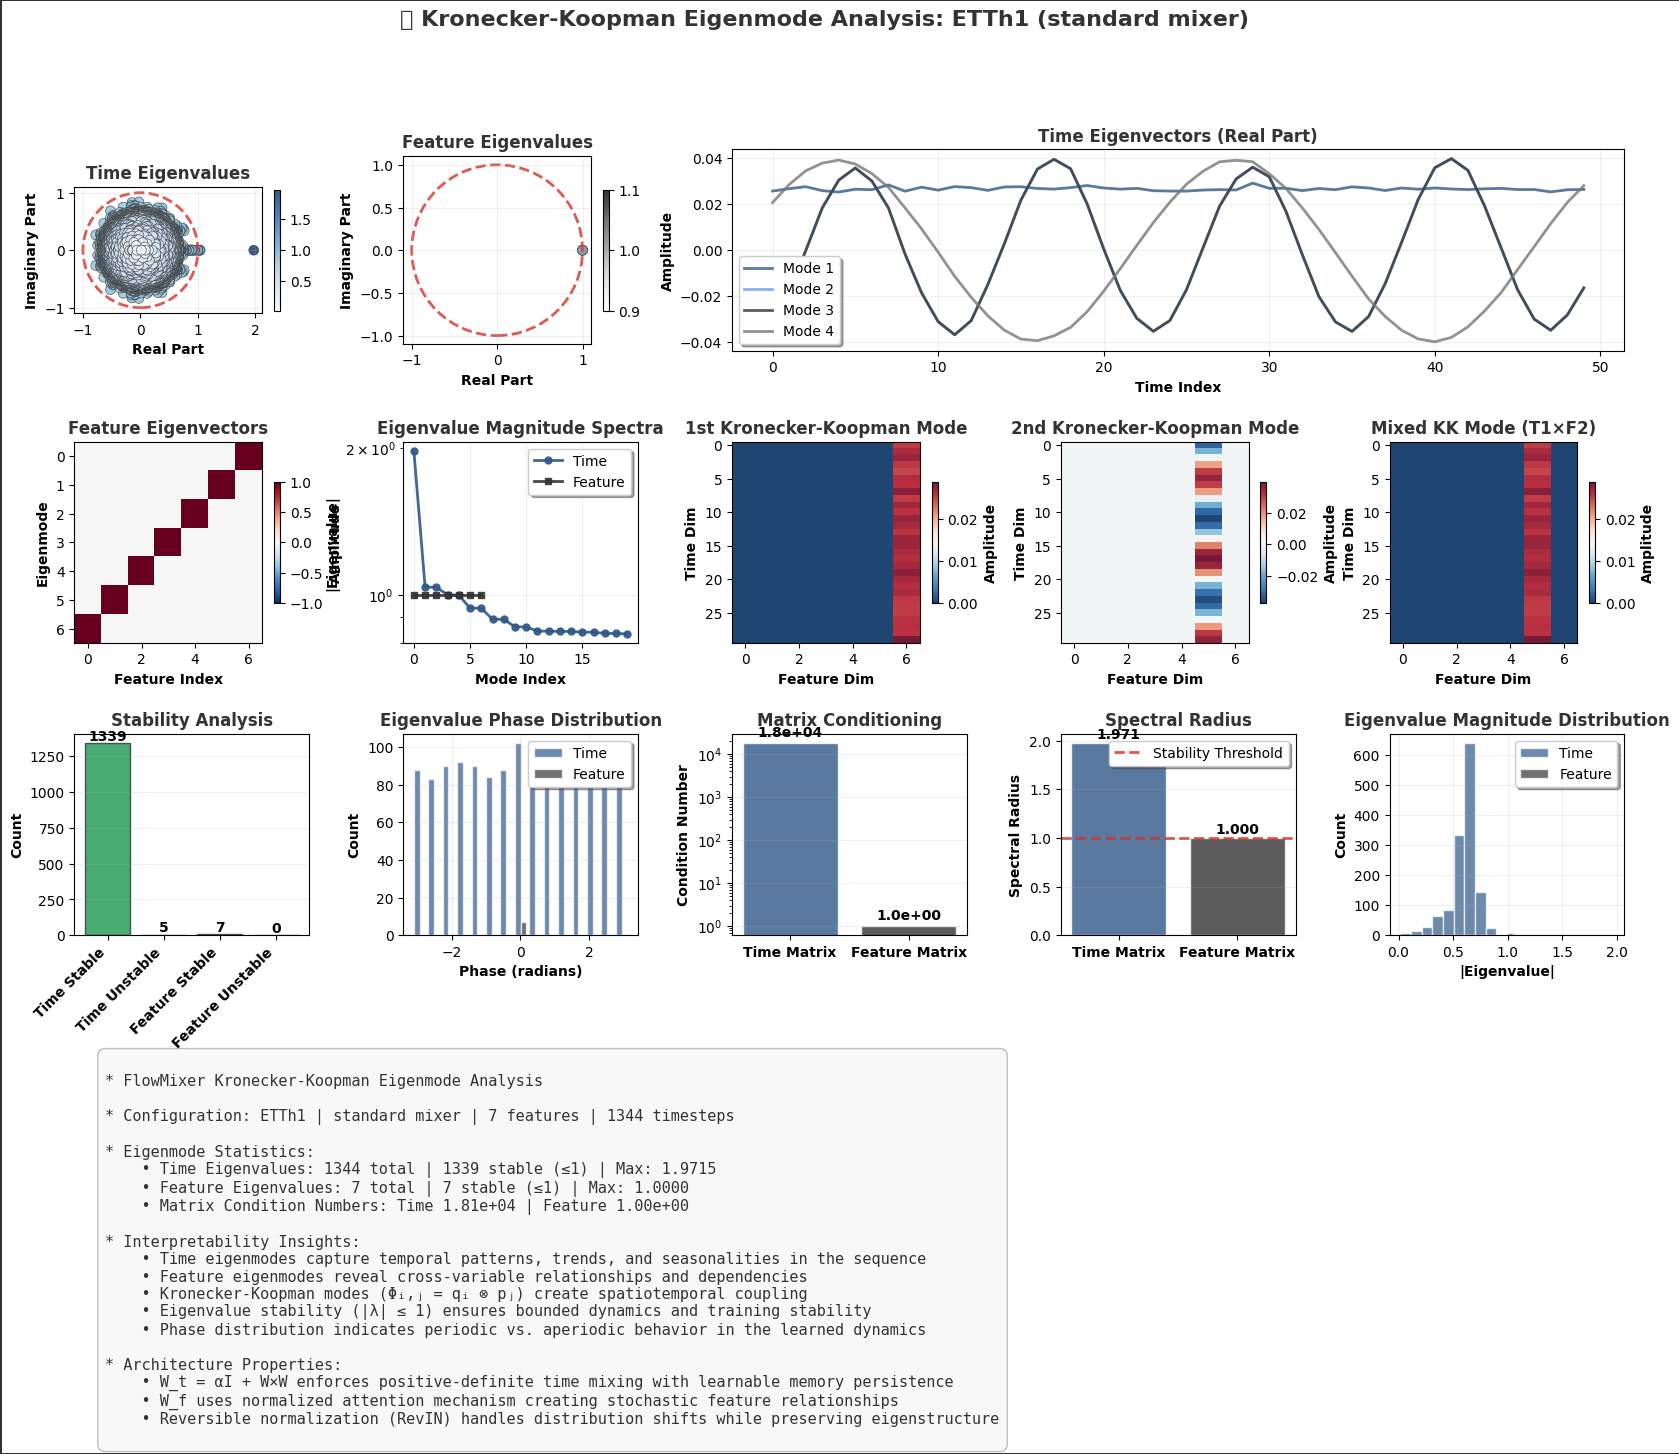


📊 Plotting training results and predictions...


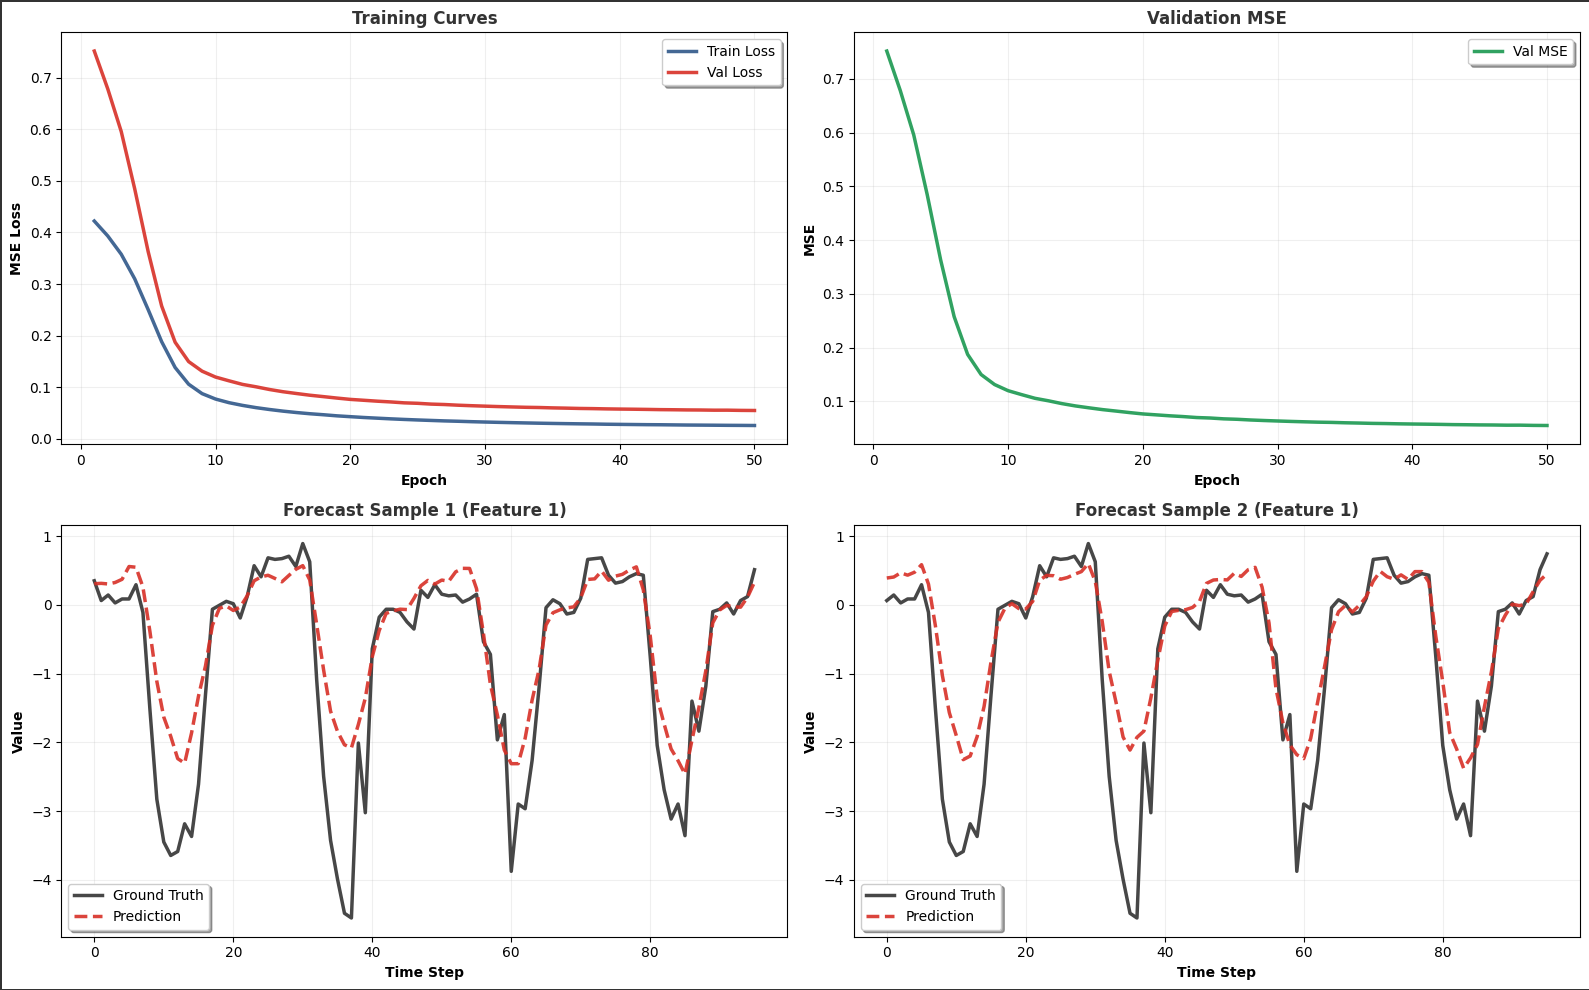


🎉 Analysis complete!
🔗 The Kronecker-Koopman framework reveals FlowMixer's interpretable spatiotemporal structure.
📈 These eigenmodes demonstrate how the model decomposes complex dynamics into interpretable components.


In [38]:
# @title Kronecker-Koopman Eigenmode Analysis & Visualization

def extract_mixing_matrices(model, sample_batch):
    """Extract W_t and W_f_T matrices from trained FlowMixer model"""
    model.eval()
    with torch.no_grad():
        Wt, Wf_T = model.get_mixing_matrices(sample_batch)
    return Wt.cpu().numpy(), Wf_T.cpu().numpy()

def compute_kronecker_koopman_eigenmodes(Wt, Wf_T):
    """Compute Kronecker-Koopman eigenmodes: W_f ⊗ W_t = PDP^-1"""
    try:
        # Eigendecomposition of time and feature matrices
        eigenvals_t, eigenvecs_t = np.linalg.eig(Wt)
        eigenvals_f, eigenvecs_f = np.linalg.eig(Wf_T)

        # Sort by eigenvalue magnitude (descending)
        idx_t = np.argsort(np.abs(eigenvals_t))[::-1]
        idx_f = np.argsort(np.abs(eigenvals_f))[::-1]

        eigenvals_t, eigenvecs_t = eigenvals_t[idx_t], eigenvecs_t[:, idx_t]
        eigenvals_f, eigenvecs_f = eigenvals_f[idx_f], eigenvecs_f[:, idx_f]

        return {
            'time_eigenvals': eigenvals_t,
            'time_eigenvecs': eigenvecs_t,
            'feature_eigenvals': eigenvals_f,
            'feature_eigenvecs': eigenvecs_f,
            'success': True
        }
    except Exception as e:
        print(f"⚠️ Eigendecomposition failed: {e}")
        return {'success': False}

def plot_kronecker_koopman_analysis(eigenmodes, config, Wt, Wf_T):
    """Create comprehensive Kronecker-Koopman eigenmode visualization"""

    if not eigenmodes['success']:
        print("❌ No eigenmode data available for plotting")
        return

    # Professional color palette
    colors = {
        'primary': '#2F5789',      # Dark blue
        'secondary': '#6E9DE3',    # Light blue
        'accent': '#333333',       # Dark gray
        'light': '#777777',        # Light gray
        'neutral': '#E8E8E8',      # Very light gray
        'warning': '#D73027',      # Professional red
        'success': '#1A9850'       # Professional green
    }

    # Extract eigenmode data
    eigenvals_t = eigenmodes['time_eigenvals']
    eigenvecs_t = eigenmodes['time_eigenvecs']
    eigenvals_f = eigenmodes['feature_eigenvals']
    eigenvecs_f = eigenmodes['feature_eigenvecs']

    # Create comprehensive visualization with professional styling
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 14), facecolor='white')
    gs = fig.add_gridspec(4, 5, hspace=0.45, wspace=0.4)  # Increased hspace from 0.35 to 0.45

    # 1. Time eigenvalues in complex plane
    ax1 = fig.add_subplot(gs[0, 0])
    scatter1 = ax1.scatter(eigenvals_t.real, eigenvals_t.imag,
                          c=np.abs(eigenvals_t), cmap='Blues', s=50, alpha=0.8, edgecolors=colors['accent'], linewidth=0.5)
    circle1 = plt.Circle((0, 0), 1, fill=False, color=colors['warning'], linestyle='--', alpha=0.8, linewidth=2)
    ax1.add_patch(circle1)
    ax1.set_xlabel('Real Part', fontweight='bold'); ax1.set_ylabel('Imaginary Part', fontweight='bold')
    ax1.set_title('Time Eigenvalues', fontweight='bold', color=colors['accent']); ax1.grid(True, alpha=0.2)
    ax1.set_aspect('equal'); plt.colorbar(scatter1, ax=ax1, shrink=0.6)

    # 2. Feature eigenvalues in complex plane
    ax2 = fig.add_subplot(gs[0, 1])
    scatter2 = ax2.scatter(eigenvals_f.real, eigenvals_f.imag,
                          c=np.abs(eigenvals_f), cmap='Greys', s=50, alpha=0.8, edgecolors=colors['primary'], linewidth=0.5)
    circle2 = plt.Circle((0, 0), 1, fill=False, color=colors['warning'], linestyle='--', alpha=0.8, linewidth=2)
    ax2.add_patch(circle2)
    ax2.set_xlabel('Real Part', fontweight='bold'); ax2.set_ylabel('Imaginary Part', fontweight='bold')
    ax2.set_title('Feature Eigenvalues', fontweight='bold', color=colors['accent']); ax2.grid(True, alpha=0.2)
    ax2.set_aspect('equal'); plt.colorbar(scatter2, ax=ax2, shrink=0.6)

    # 3. Time eigenvectors (first few modes)
    ax3 = fig.add_subplot(gs[0, 2:])
    n_show_time = min(50, len(eigenvals_t))
    mode_colors = [colors['primary'], colors['secondary'], colors['accent'], colors['light']]
    for i in range(min(4, eigenvecs_t.shape[1])):
        ax3.plot(eigenvecs_t[:n_show_time, i].real, label=f'Mode {i+1}',
                linewidth=2, alpha=0.8, color=mode_colors[i])
    ax3.set_xlabel('Time Index', fontweight='bold'); ax3.set_ylabel('Amplitude', fontweight='bold')
    ax3.set_title('Time Eigenvectors (Real Part)', fontweight='bold', color=colors['accent'])
    ax3.legend(frameon=True, fancybox=True, shadow=True); ax3.grid(True, alpha=0.2)

    # 4. Feature eigenvectors heatmap
    ax4 = fig.add_subplot(gs[1, 0])
    n_show_feat = min(8, eigenvecs_f.shape[1])
    im1 = ax4.imshow(eigenvecs_f[:, :n_show_feat].real.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    ax4.set_xlabel('Feature Index', fontweight='bold'); ax4.set_ylabel('Eigenmode', fontweight='bold')
    ax4.set_title('Feature Eigenvectors', fontweight='bold', color=colors['accent'])
    cbar1 = plt.colorbar(im1, ax=ax4, shrink=0.6); cbar1.set_label('Amplitude', fontweight='bold')

    # 5. Eigenvalue magnitude spectra
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.semilogy(np.abs(eigenvals_t)[:20], 'o-', label='Time', alpha=0.9, markersize=5,
                linewidth=2, color=colors['primary'])
    ax5.semilogy(np.abs(eigenvals_f)[:20], 's-', label='Feature', alpha=0.9, markersize=5,
                linewidth=2, color=colors['accent'])
    ax5.set_xlabel('Mode Index', fontweight='bold'); ax5.set_ylabel('|Eigenvalue|', fontweight='bold')
    ax5.set_title('Eigenvalue Magnitude Spectra', fontweight='bold', color=colors['accent'])
    ax5.legend(frameon=True, fancybox=True, shadow=True); ax5.grid(True, alpha=0.2)

    # 6. Dominant Kronecker-Koopman modes
    ax6 = fig.add_subplot(gs[1, 2])
    n_t_show, n_f_show = min(30, len(eigenvals_t)), min(config['n_features'], 10)
    if len(eigenvals_t) > 0 and len(eigenvals_f) > 0:
        # First KK mode
        kk_mode_1 = np.outer(eigenvecs_t[:n_t_show, 0].real, eigenvecs_f[:n_f_show, 0].real)
        im2 = ax6.imshow(kk_mode_1, aspect='auto', cmap='RdBu_r', alpha=0.9)
        ax6.set_xlabel('Feature Dim', fontweight='bold'); ax6.set_ylabel('Time Dim', fontweight='bold')
        ax6.set_title('1st Kronecker-Koopman Mode', fontweight='bold', color=colors['accent'])
        cbar2 = plt.colorbar(im2, ax=ax6, shrink=0.6); cbar2.set_label('Amplitude', fontweight='bold')

    # 7. Second KK mode
    ax7 = fig.add_subplot(gs[1, 3])
    if len(eigenvals_t) > 1 and len(eigenvals_f) > 1:
        kk_mode_2 = np.outer(eigenvecs_t[:n_t_show, 1].real, eigenvecs_f[:n_f_show, 1].real)
        im3 = ax7.imshow(kk_mode_2, aspect='auto', cmap='RdBu_r', alpha=0.9)
        ax7.set_xlabel('Feature Dim', fontweight='bold'); ax7.set_ylabel('Time Dim', fontweight='bold')
        ax7.set_title('2nd Kronecker-Koopman Mode', fontweight='bold', color=colors['accent'])
        cbar3 = plt.colorbar(im3, ax=ax7, shrink=0.6); cbar3.set_label('Amplitude', fontweight='bold')

    # 8. Mixed KK mode (time mode 1 × feature mode 2)
    ax8 = fig.add_subplot(gs[1, 4])
    if len(eigenvals_t) > 0 and len(eigenvals_f) > 1:
        kk_mode_mixed = np.outer(eigenvecs_t[:n_t_show, 0].real, eigenvecs_f[:n_f_show, 1].real)
        im4 = ax8.imshow(kk_mode_mixed, aspect='auto', cmap='RdBu_r', alpha=0.9)
        ax8.set_xlabel('Feature Dim', fontweight='bold'); ax8.set_ylabel('Time Dim', fontweight='bold')
        ax8.set_title('Mixed KK Mode (T1×F2)', fontweight='bold', color=colors['accent'])
        cbar4 = plt.colorbar(im4, ax=ax8, shrink=0.6); cbar4.set_label('Amplitude', fontweight='bold')

    # 9. Stability analysis
    ax9 = fig.add_subplot(gs[2, 0])
    stable_t = np.abs(eigenvals_t) <= 1.0
    stable_f = np.abs(eigenvals_f) <= 1.0

    stability_data = {
        'Time Stable': np.sum(stable_t),
        'Time Unstable': np.sum(~stable_t),
        'Feature Stable': np.sum(stable_f),
        'Feature Unstable': np.sum(~stable_f)
    }

    bar_colors = [colors['success'], colors['warning'], colors['primary'], colors['secondary']]
    bars = ax9.bar(stability_data.keys(), stability_data.values(), color=bar_colors, alpha=0.8, edgecolor=colors['accent'])
    ax9.set_ylabel('Count', fontweight='bold'); ax9.set_title('Stability Analysis', fontweight='bold', color=colors['accent'])
    plt.setp(ax9.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    ax9.grid(True, alpha=0.2, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars, stability_data.values()):
        ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 10. Eigenvalue phase distribution
    ax10 = fig.add_subplot(gs[2, 1])
    phases_t = np.angle(eigenvals_t)
    phases_f = np.angle(eigenvals_f)
    ax10.hist([phases_t, phases_f], bins=15, alpha=0.7, label=['Time', 'Feature'],
             color=[colors['primary'], colors['accent']], edgecolor='white', linewidth=1)
    ax10.set_xlabel('Phase (radians)', fontweight='bold'); ax10.set_ylabel('Count', fontweight='bold')
    ax10.set_title('Eigenvalue Phase Distribution', fontweight='bold', color=colors['accent'])
    ax10.legend(frameon=True, fancybox=True, shadow=True); ax10.grid(True, alpha=0.2)

    # 11. Matrix condition numbers
    ax11 = fig.add_subplot(gs[2, 2])
    cond_t = np.linalg.cond(Wt)
    cond_f = np.linalg.cond(Wf_T)

    bars11 = ax11.bar(['Time Matrix', 'Feature Matrix'], [cond_t, cond_f],
                     color=[colors['primary'], colors['accent']], alpha=0.8, edgecolor='white', linewidth=1)
    ax11.set_ylabel('Condition Number', fontweight='bold'); ax11.set_title('Matrix Conditioning', fontweight='bold', color=colors['accent'])
    ax11.set_yscale('log'); ax11.grid(True, alpha=0.2, axis='y')
    plt.setp(ax11.get_xticklabels(), fontweight='bold')

    # Add value labels
    ax11.text(0, cond_t * 1.2, f'{cond_t:.1e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax11.text(1, cond_f * 1.2, f'{cond_f:.1e}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 12. Spectral radius
    ax12 = fig.add_subplot(gs[2, 3])
    spectral_t = np.max(np.abs(eigenvals_t))
    spectral_f = np.max(np.abs(eigenvals_f))

    bars12 = ax12.bar(['Time Matrix', 'Feature Matrix'], [spectral_t, spectral_f],
                     color=[colors['primary'], colors['accent']], alpha=0.8, edgecolor='white', linewidth=1)
    ax12.set_ylabel('Spectral Radius', fontweight='bold'); ax12.set_title('Spectral Radius', fontweight='bold', color=colors['accent'])
    ax12.axhline(y=1, color=colors['warning'], linestyle='--', alpha=0.8, linewidth=2, label='Stability Threshold')
    ax12.legend(frameon=True, fancybox=True, shadow=True); ax12.grid(True, alpha=0.2, axis='y')
    plt.setp(ax12.get_xticklabels(), fontweight='bold')

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars12, [spectral_t, spectral_f])):
        ax12.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 13. Eigenvalue density (magnitude)
    ax13 = fig.add_subplot(gs[2, 4])
    ax13.hist(np.abs(eigenvals_t), bins=20, alpha=0.7, label='Time', color=colors['primary'], edgecolor='white', linewidth=1)
    ax13.hist(np.abs(eigenvals_f), bins=20, alpha=0.7, label='Feature', color=colors['accent'], edgecolor='white', linewidth=1)
    ax13.set_xlabel('|Eigenvalue|', fontweight='bold'); ax13.set_ylabel('Count', fontweight='bold')
    ax13.set_title('Eigenvalue Magnitude Distribution', fontweight='bold', color=colors['accent'])
    ax13.legend(frameon=True, fancybox=True, shadow=True); ax13.grid(True, alpha=0.2)

    # 14. Information summary
    ax14 = fig.add_subplot(gs[3, :])
    ax14.axis('off')

    # Calculate key statistics
    max_time_eigenval = np.max(np.abs(eigenvals_t))
    max_feat_eigenval = np.max(np.abs(eigenvals_f))
    n_stable_time = np.sum(np.abs(eigenvals_t) <= 1.0)
    n_stable_feat = np.sum(np.abs(eigenvals_f) <= 1.0)

    info_text = f"""
* FlowMixer Kronecker-Koopman Eigenmode Analysis

* Configuration: {config['dataset']} | {config['mixer_type']} mixer | {config['n_features']} features | {config['seq_len']} timesteps

* Eigenmode Statistics:
    • Time Eigenvalues: {len(eigenvals_t)} total | {n_stable_time} stable (≤1) | Max: {max_time_eigenval:.4f}
    • Feature Eigenvalues: {len(eigenvals_f)} total | {n_stable_feat} stable (≤1) | Max: {max_feat_eigenval:.4f}
    • Matrix Condition Numbers: Time {cond_t:.2e} | Feature {cond_f:.2e}

* Interpretability Insights:
    • Time eigenmodes capture temporal patterns, trends, and seasonalities in the sequence
    • Feature eigenmodes reveal cross-variable relationships and dependencies
    • Kronecker-Koopman modes (Φᵢ,ⱼ = qᵢ ⊗ pⱼ) create spatiotemporal coupling
    • Eigenvalue stability (|λ| ≤ 1) ensures bounded dynamics and training stability
    • Phase distribution indicates periodic vs. aperiodic behavior in the learned dynamics

* Architecture Properties:
    • W_t = αI + W×W enforces positive-definite time mixing with learnable memory persistence
    • W_f uses normalized attention mechanism creating stochastic feature relationships
    • Reversible normalization (RevIN) handles distribution shifts while preserving eigenstructure
    """

    ax14.text(0.02, 0.85, info_text, transform=ax14.transAxes, fontsize=11,  # Moved from 0.98 to 0.85
             verticalalignment='top', fontfamily='monospace', color=colors['accent'],
             bbox=dict(boxstyle='round,pad=0.5', facecolor=colors['neutral'], alpha=0.3, edgecolor=colors['accent'], linewidth=1))

    plt.suptitle(f'🔬 Kronecker-Koopman Eigenmode Analysis: {config["dataset"]} ({config["mixer_type"]} mixer)',
                 fontsize=16, fontweight='bold', y=0.98, color=colors['accent'])

    # Set overall figure styling
    fig.patch.set_facecolor('white')
    fig.patch.set_edgecolor(colors['accent'])
    fig.patch.set_linewidth(2)

    plt.tight_layout()
    plt.show()

def plot_training_and_prediction_results(results):
    """Plot training curves and sample predictions"""

    if not show_training_curves and not show_predictions:
        return

    # Professional color palette (consistent with eigenmode analysis)
    colors = {
        'primary': '#2F5789',      # Dark blue
        'secondary': '#6E9DE3',    # Light blue
        'accent': '#333333',       # Dark gray
        'light': '#777777',        # Light gray
        'warning': '#D73027',      # Professional red
        'success': '#1A9850'       # Professional green
    }

    fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white')

    if show_training_curves:
        # Training curves
        history = results['history']
        epochs_range = range(1, len(history['train_loss']) + 1)

        # Loss curves
        axes[0,0].plot(epochs_range, history['train_loss'], color=colors['primary'],
                      label='Train Loss', alpha=0.9, linewidth=2.5)
        axes[0,0].plot(epochs_range, history['val_loss'], color=colors['warning'],
                      label='Val Loss', alpha=0.9, linewidth=2.5)
        axes[0,0].set_xlabel('Epoch', fontweight='bold'); axes[0,0].set_ylabel('MSE Loss', fontweight='bold')
        axes[0,0].set_title('Training Curves', fontweight='bold', color=colors['accent'])
        axes[0,0].legend(frameon=True, fancybox=True, shadow=True); axes[0,0].grid(True, alpha=0.2)

        # Validation MSE
        axes[0,1].plot(epochs_range, history['val_mse'], color=colors['success'],
                      label='Val MSE', alpha=0.9, linewidth=2.5)
        axes[0,1].set_xlabel('Epoch', fontweight='bold'); axes[0,1].set_ylabel('MSE', fontweight='bold')
        axes[0,1].set_title('Validation MSE', fontweight='bold', color=colors['accent'])
        axes[0,1].legend(frameon=True, fancybox=True, shadow=True); axes[0,1].grid(True, alpha=0.2)

    if show_predictions:
        # Sample predictions
        preds = results['test_predictions'][:3]  # First 3 samples
        targets = results['test_targets'][:3]

        # First sample - first feature
        ax = axes[1, 0]
        time_steps = range(preds.shape[1])
        ax.plot(time_steps, targets[0, :, 0].numpy(), color=colors['accent'],
               label='Ground Truth', linewidth=2.5, alpha=0.9)
        ax.plot(time_steps, preds[0, :, 0].numpy(), color=colors['warning'],
               label='Prediction', linewidth=2.5, alpha=0.9, linestyle='--')
        ax.set_xlabel('Time Step', fontweight='bold'); ax.set_ylabel('Value', fontweight='bold')
        ax.set_title(f'Forecast Sample 1 (Feature 1)', fontweight='bold', color=colors['accent'])
        ax.legend(frameon=True, fancybox=True, shadow=True); ax.grid(True, alpha=0.2)

        # Second sample - first feature
        ax = axes[1, 1]
        ax.plot(time_steps, targets[1, :, 0].numpy(), color=colors['accent'],
               label='Ground Truth', linewidth=2.5, alpha=0.9)
        ax.plot(time_steps, preds[1, :, 0].numpy(), color=colors['warning'],
               label='Prediction', linewidth=2.5, alpha=0.9, linestyle='--')
        ax.set_xlabel('Time Step', fontweight='bold'); ax.set_ylabel('Value', fontweight='bold')
        ax.set_title(f'Forecast Sample 2 (Feature 1)', fontweight='bold', color=colors['accent'])
        ax.legend(frameon=True, fancybox=True, shadow=True); ax.grid(True, alpha=0.2)

    # Set overall figure styling
    fig.patch.set_facecolor('white')
    fig.patch.set_edgecolor(colors['accent'])
    fig.patch.set_linewidth(1)

    plt.tight_layout()
    plt.show()

# Execute Analysis
if experiment_results and show_eigenmode_analysis:
    print("\n" + "="*60)
    print("🔬 KRONECKER-KOOPMAN EIGENMODE ANALYSIS")
    print("="*60)

    # Get sample batch for matrix extraction
    sample_batch = next(iter(experiment_results['dataset_manager'].get_dataloaders()[2]))[0][:1].to(device)

    # Extract mixing matrices
    print("📐 Extracting mixing matrices...")
    Wt, Wf_T = extract_mixing_matrices(experiment_results['model'], sample_batch)
    print(f"   W_t shape: {Wt.shape} | W_f^T shape: {Wf_T.shape}")

    # Compute eigenmode decomposition
    print("🧮 Computing eigenmode decomposition...")
    eigenmodes = compute_kronecker_koopman_eigenmodes(Wt, Wf_T)

    if eigenmodes['success']:
        print(f"   ✅ Eigendecomposition successful!")
        print(f"   Time eigenvalues: {len(eigenmodes['time_eigenvals'])}")
        print(f"   Feature eigenvalues: {len(eigenmodes['feature_eigenvals'])}")

        # Create comprehensive visualization
        print("🎨 Creating eigenmode visualization...")
        plot_kronecker_koopman_analysis(eigenmodes, experiment_results['config'], Wt, Wf_T)
    else:
        print("❌ Eigendecomposition failed")

# Plot training results and predictions
if experiment_results and (show_training_curves or show_predictions):
    print("\n📊 Plotting training results and predictions...")
    plot_training_and_prediction_results(experiment_results)

if experiment_results:
    print("\n🎉 Analysis complete!")
    print("🔗 The Kronecker-Koopman framework reveals FlowMixer's interpretable spatiotemporal structure.")
    print("📈 These eigenmodes demonstrate how the model decomposes complex dynamics into interpretable components.")
else:
    print("❌ No experiment results available for analysis.")